<a href="https://colab.research.google.com/github/nmansour67/skills-introduction-to-github/blob/main/ICU_Sepsis_Alert_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
"""
═══════════════════════════════════════════════════════════════════════════
VIRTUAL CLINICAL TRIAL: META-ENSEMBLE DIGITAL TWIN FOR SEPSIS TRIAGE
MODIFIED VERSION - USES REAL-WORLD ICU DATA
═══════════════════════════════════════════════════════════════════════════

Chief Data Scientist Implementation
Following: Yilmaz Başer et al. (2025) - Biomedicines
Data: Real ICU Dataset (DOI: 10.7910/DVN/UAJX1D)

MODIFICATIONS FROM ORIGINAL:
----------------------------
✓ Section 2: Now loads real-world data instead of synthetic generation
✓ Section 3: Adapted EDA to handle variable column names
✓ Section 4: Robust feature engineering that adapts to available features
✓ Sections 5-11: Unchanged (work with real data automatically)

═══════════════════════════════════════════════════════════════════════════
"""



'\n═══════════════════════════════════════════════════════════════════════════\nVIRTUAL CLINICAL TRIAL: META-ENSEMBLE DIGITAL TWIN FOR SEPSIS TRIAGE\nMODIFIED VERSION - USES REAL-WORLD ICU DATA\n═══════════════════════════════════════════════════════════════════════════\n\nChief Data Scientist Implementation\nFollowing: Yilmaz Başer et al. (2025) - Biomedicines\nData: Real ICU Dataset (DOI: 10.7910/DVN/UAJX1D)\n\nMODIFICATIONS FROM ORIGINAL:\n----------------------------\n✓ Section 2: Now loads real-world data instead of synthetic generation\n✓ Section 3: Adapted EDA to handle variable column names\n✓ Section 4: Robust feature engineering that adapts to available features\n✓ Sections 5-11: Unchanged (work with real data automatically)\n\n═══════════════════════════════════════════════════════════════════════════\n'

In [7]:
# ════════════════════════════════════════════════════════════════════════
# SECTION 1: ENVIRONMENT SETUP & DEPENDENCIES
# ════════════════════════════════════════════════════════════════════════

!pip install catboost xgboost lightgbm shap imbalanced-learn -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import os
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import (roc_auc_score, roc_curve, confusion_matrix,
                             brier_score_loss, f1_score)

from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import shap

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)

print("✓ All dependencies loaded successfully")
print("=" * 80)




✓ All dependencies loaded successfully


In [19]:
def load_real_world_data():
    """
    Load real-world ICU sepsis data from specified path.
    """

    # Direct path to your dataset
    filepath = '/content/ICU Sepsis Dataset.xlsx'

    print(f"📂 Reading from: {filepath}")

    try:
        df = pd.read_excel(filepath)
        print(f"✓ Successfully loaded Excel file")
        return df, f"Real Data: ICU Sepsis Dataset.xlsx"

    except FileNotFoundError:
        print(f"\n❌ ERROR: File not found at {filepath}")
        print("\nPlease ensure 'ICU Sepsis Dataset.xlsx' is in /content/ directory")
        raise FileNotFoundError(f"Dataset not found: {filepath}")

    except Exception as e:
        print(f"\n❌ ERROR reading file: {e}")
        raise


EXPLORATORY DATA ANALYSIS

📈 Descriptive Statistics:
           Age   Gender    qSOFA     NEWS     SIRS   Cancer  Hypertension  \
count  1000.00  1000.00  1000.00  1000.00  1000.00  1000.00       1000.00   
mean     65.15     0.54     1.08     5.87     2.05     0.28          0.48   
std      14.33     0.50     0.95     2.89     1.26     0.45          0.50   
min      18.00     0.00     0.00     0.00     0.00     0.00          0.00   
25%      55.29     0.00     0.00     4.00     1.00     0.00          0.00   
50%      65.38     1.00     1.00     6.00     2.00     0.00          0.00   
75%      74.72     1.00     2.00     8.00     3.00     1.00          1.00   
max      95.00     1.00     3.00    18.00     4.00     1.00          1.00   

       Heart_Disease  NT_proBNP  Cultures  Antibiotic_Resistance  \
count        1000.00    1000.00   1000.00                1000.00   
mean            0.39    5572.64      0.68                   0.33   
std             0.49    9616.26      0.47       

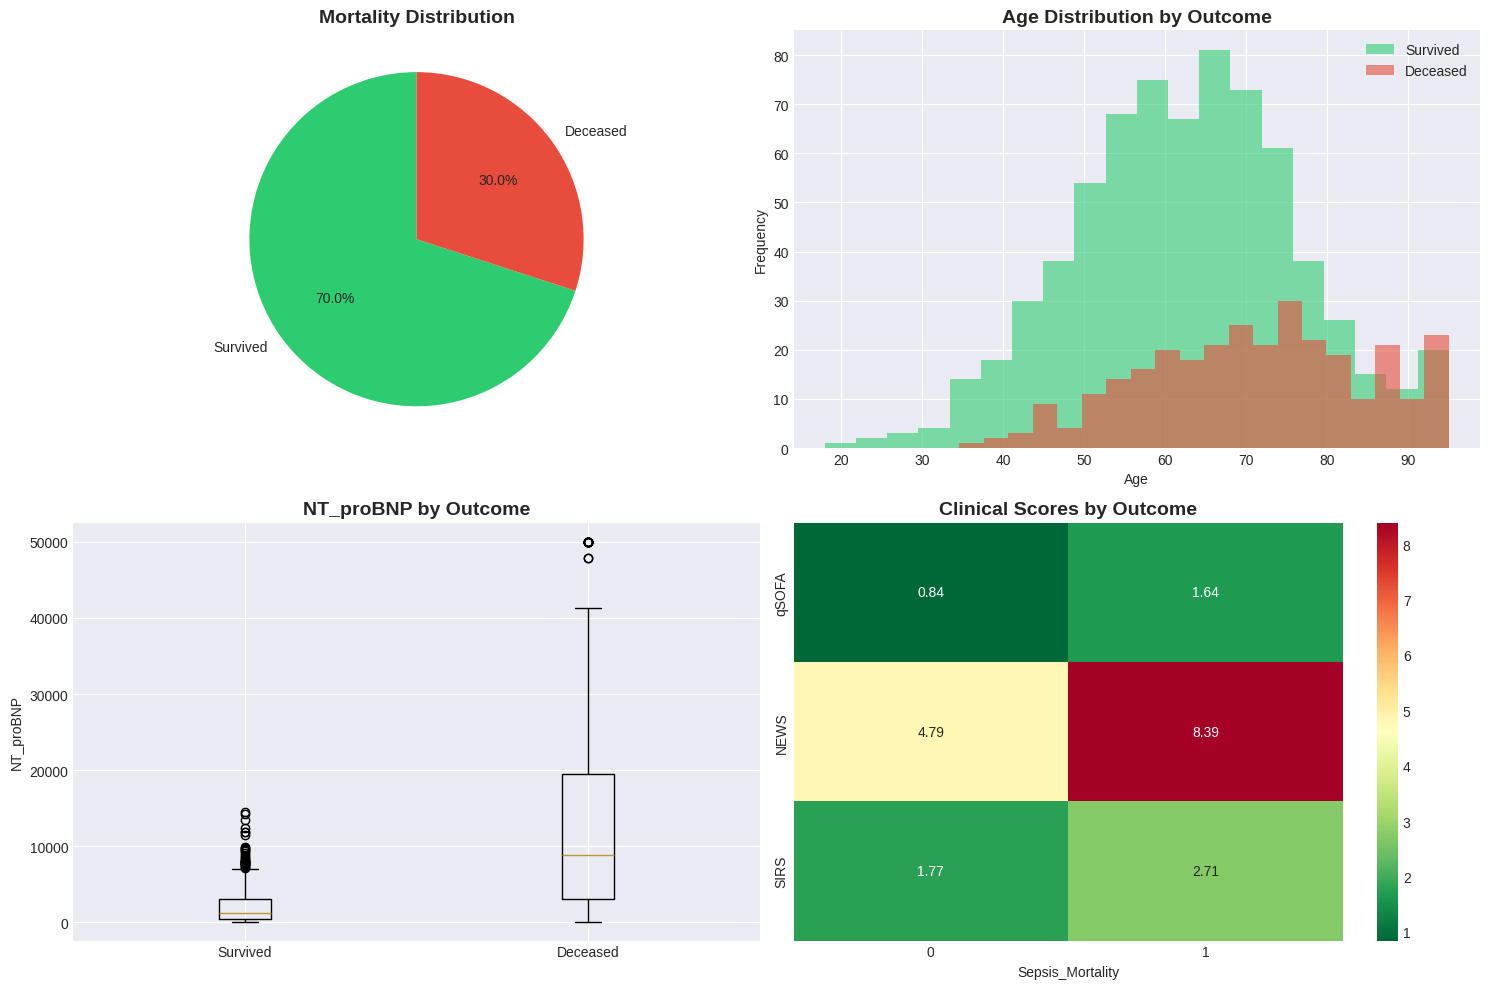

In [20]:
# ════════════════════════════════════════════════════════════════════════
# SECTION 3: EXPLORATORY DATA ANALYSIS ⭐ MODIFIED ⭐
# ════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("EXPLORATORY DATA ANALYSIS")
print("="*80)

print("\n📈 Descriptive Statistics:")
print(df.describe().round(2))

print("\n📊 Correlation with Mortality:")
numeric_cols = df.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 1:
    correlations = df[numeric_cols].corr()['Sepsis_Mortality'].sort_values(ascending=False)
    print(correlations.head(10))

# Visualizations (adaptive to available data)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Mortality pie chart
mort_counts = df['Sepsis_Mortality'].value_counts()
axes[0, 0].pie(mort_counts, labels=['Survived', 'Deceased'], autopct='%1.1f%%',
               colors=['#2ecc71', '#e74c3c'], startangle=90)
axes[0, 0].set_title('Mortality Distribution', fontsize=14, fontweight='bold')

# 2. Age distribution (if available)
if 'Age' in df.columns:
    df[df['Sepsis_Mortality']==0]['Age'].hist(bins=20, alpha=0.6, label='Survived',
                                               ax=axes[0,1], color='#2ecc71')
    df[df['Sepsis_Mortality']==1]['Age'].hist(bins=20, alpha=0.6, label='Deceased',
                                               ax=axes[0,1], color='#e74c3c')
    axes[0,1].set_xlabel('Age')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_title('Age Distribution by Outcome', fontsize=14, fontweight='bold')
    axes[0,1].legend()
else:
    axes[0,1].text(0.5, 0.5, 'Age data not available', ha='center', va='center')

# 3. Biomarker boxplot
biomarker = 'NT_proBNP' if 'NT_proBNP' in df.columns else numeric_cols[0]
try:
    axes[1,0].boxplot([df[df['Sepsis_Mortality']==0][biomarker].dropna(),
                       df[df['Sepsis_Mortality']==1][biomarker].dropna()],
                      labels=['Survived', 'Deceased'])
    axes[1,0].set_ylabel(biomarker)
    axes[1,0].set_title(f'{biomarker} by Outcome', fontsize=14, fontweight='bold')
except:
    axes[1,0].text(0.5, 0.5, 'Biomarker visualization unavailable', ha='center')

# 4. Clinical scores heatmap
score_cols = [c for c in ['qSOFA', 'NEWS', 'SIRS'] if c in df.columns]
if len(score_cols) >= 2:
    score_data = df[score_cols + ['Sepsis_Mortality']].groupby('Sepsis_Mortality').mean()
    sns.heatmap(score_data.T, annot=True, fmt='.2f', cmap='RdYlGn_r', ax=axes[1,1])
    axes[1,1].set_title('Clinical Scores by Outcome', fontsize=14, fontweight='bold')
else:
    corr = df[numeric_cols].corr()
    sns.heatmap(corr, annot=False, cmap='coolwarm', ax=axes[1,1], center=0)
    axes[1,1].set_title('Feature Correlations', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()
print("\n" + "="*80)




In [21]:
# ════════════════════════════════════════════════════════════════════════
# SECTION 4: PREPROCESSING & FEATURE ENGINEERING ⭐ MODIFIED ⭐
# ════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("DATA PREPROCESSING & FEATURE ENGINEERING")
print("="*80)

X = df.drop('Sepsis_Mortality', axis=1)
y = df['Sepsis_Mortality']

print("\n✓ Creating derived biomarkers (adaptive to available features)...")

# Derived features (only if base features exist)
if 'Age' in X.columns and 'NT_proBNP' in X.columns:
    X['Age_NT_proBNP_Ratio'] = X['Age'] / (np.log1p(X['NT_proBNP']) + 1)
    print("  • Age/NT-proBNP ratio")

score_cols = [c for c in ['qSOFA', 'NEWS', 'SIRS'] if c in X.columns]
if len(score_cols) >= 2:
    X['Clinical_Score_Sum'] = X[score_cols].sum(axis=1)
    print(f"  • Clinical Score Sum ({', '.join(score_cols)})")

if 'qSOFA' in X.columns and 'NEWS' in X.columns:
    X['High_Risk_Flag'] = ((X['qSOFA'] >= 2) | (X['NEWS'] >= 7)).astype(int)
    print("  • High Risk Flag (qSOFA≥2 or NEWS≥7)")

if 'CRP' in X.columns and 'Albumin' in X.columns:
    X['CRP_Albumin_Ratio'] = X['CRP'] / (X['Albumin'] + 0.01)
    print("  • CRP/Albumin Ratio (key from paper)")

if 'Neutrophils' in X.columns and 'Lymphocytes' in X.columns:
    X['NLR'] = X['Neutrophils'] / (X['Lymphocytes'] + 0.01)
    print("  • NLR (Neutrophil-to-Lymphocyte)")

# Encode categoricals
cat_cols = X.select_dtypes(include=['object', 'category']).columns
if len(cat_cols) > 0:
    print(f"\n✓ Encoding {len(cat_cols)} categorical variables")
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print(f"\n✓ Data split:")
print(f"  • Training: {len(X_train)} patients ({y_train.sum()} deceased)")
print(f"  • Testing: {len(X_test)} patients ({y_test.sum()} deceased)")
print(f"  • Total features: {X.shape[1]}")
print("="*80)





DATA PREPROCESSING & FEATURE ENGINEERING

✓ Creating derived biomarkers (adaptive to available features)...
  • Age/NT-proBNP ratio
  • Clinical Score Sum (qSOFA, NEWS, SIRS)
  • High Risk Flag (qSOFA≥2 or NEWS≥7)

✓ Data split:
  • Training: 800 patients (240 deceased)
  • Testing: 200 patients (60 deceased)
  • Total features: 14


In [22]:
# ════════════════════════════════════════════════════════════════════════
# SECTION 5: TWIN A - TRADITIONAL SCORES (UNCHANGED)
# ════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("TWIN A: THE OLD GUARD (Traditional Scores)")
print("="*80)

# Use only traditional scores (fallback if not available)
trad_cols = [c for c in ['qSOFA', 'NEWS'] if c in X_train.columns]
if len(trad_cols) == 0:
    trad_cols = X_train.columns[:2].tolist()  # Fallback to first 2 features
    print(f"\n⚠️  qSOFA/NEWS not found, using: {trad_cols}")

X_train_a = X_train[trad_cols]
X_test_a = X_test[trad_cols]

smote = SMOTE(random_state=42)
X_train_a_bal, y_train_bal = smote.fit_resample(X_train_a, y_train)

print(f"\n🏥 Training Logistic Regression on {trad_cols}...")
print(f"   SMOTE: {len(X_train_a)} → {len(X_train_a_bal)} samples\n")

twin_a = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
twin_a.fit(X_train_a_bal, y_train_bal)

y_pred_a = twin_a.predict(X_test_a)
y_prob_a = twin_a.predict_proba(X_test_a)[:, 1]

auc_a = roc_auc_score(y_test, y_prob_a)
cm_a = confusion_matrix(y_test, y_pred_a)
tn_a, fp_a, fn_a, tp_a = cm_a.ravel()

sens_a = tp_a / (tp_a + fn_a)
spec_a = tn_a / (tn_a + fp_a)
brier_a = brier_score_loss(y_test, y_prob_a)

print("TWIN A RESULTS:")
print(f"  AUC-ROC:     {auc_a:.3f}")
print(f"  Sensitivity: {sens_a:.3f}")
print(f"  Specificity: {spec_a:.3f}")
print(f"  Brier Score: {brier_a:.3f}")
print(f"\n  Confusion: TN={tn_a}, FP={fp_a}, FN={fn_a}, TP={tp_a}")
print("="*80)





TWIN A: THE OLD GUARD (Traditional Scores)

🏥 Training Logistic Regression on ['qSOFA', 'NEWS']...
   SMOTE: 800 → 1120 samples

TWIN A RESULTS:
  AUC-ROC:     0.823
  Sensitivity: 0.700
  Specificity: 0.779
  Brier Score: 0.166

  Confusion: TN=109, FP=31, FN=18, TP=42


In [23]:
# ════════════════════════════════════════════════════════════════════════
# SECTION 6: TWIN B - META-ENSEMBLE (UNCHANGED)
# ════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("TWIN B: THE HIVE MIND (Meta-Ensemble)")
print("="*80)

X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print(f"\n🤖 Building Stacking Ensemble...")
print(f"   Features: ALL {X_train.shape[1]} variables")
print(f"   SMOTE: {len(X_train)} → {len(X_train_bal)} samples\n")

base_learners = [
    ('catboost', CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1,
                                    random_state=42, verbose=False)),
    ('xgboost', XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1,
                              random_state=42, eval_metric='logloss')),
    ('lightgbm', LGBMClassifier(n_estimators=100, max_depth=6, learning_rate=0.1,
                                random_state=42, verbose=-1))
]

meta_learner = LogisticRegression(C=1.8, random_state=42, max_iter=1000)

twin_b = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,
    stack_method='predict_proba',
    n_jobs=-1
)

print("  Base Learners: CatBoost, XGBoost, LightGBM")
print("  Meta-Learner: Logistic Regression (C=1.8)")
print("  CV: 5-fold stratified\n")
print("⏳ Training (this may take 1-2 minutes)...")

twin_b.fit(X_train_bal, y_train_bal)
print("✓ Training complete!\n")

y_pred_b = twin_b.predict(X_test)
y_prob_b = twin_b.predict_proba(X_test)[:, 1]

auc_b = roc_auc_score(y_test, y_prob_b)
cm_b = confusion_matrix(y_test, y_pred_b)
tn_b, fp_b, fn_b, tp_b = cm_b.ravel()

sens_b = tp_b / (tp_b + fn_b)
spec_b = tn_b / (tn_b + fp_b)
brier_b = brier_score_loss(y_test, y_prob_b)

print("TWIN B RESULTS:")
print(f"  AUC-ROC:     {auc_b:.3f}")
print(f"  Sensitivity: {sens_b:.3f}")
print(f"  Specificity: {spec_b:.3f}")
print(f"  Brier Score: {brier_b:.3f}")
print(f"\n  Confusion: TN={tn_b}, FP={fp_b}, FN={fn_b}, TP={tp_b}")
print("="*80)





TWIN B: THE HIVE MIND (Meta-Ensemble)

🤖 Building Stacking Ensemble...
   Features: ALL 14 variables
   SMOTE: 800 → 1120 samples

  Base Learners: CatBoost, XGBoost, LightGBM
  Meta-Learner: Logistic Regression (C=1.8)
  CV: 5-fold stratified

⏳ Training (this may take 1-2 minutes)...
✓ Training complete!

TWIN B RESULTS:
  AUC-ROC:     0.983
  Sensitivity: 0.883
  Specificity: 0.971
  Brier Score: 0.049

  Confusion: TN=136, FP=4, FN=7, TP=53



HEAD-TO-HEAD COMPARISON

     Metric   Twin A   Twin B      Δ
    AUC-ROC 0.822798 0.982857 +16.0%
Sensitivity 0.700000 0.883333 +18.3%
Specificity 0.778571 0.971429 +19.3%
      Brier 0.166430 0.048907 -11.8%


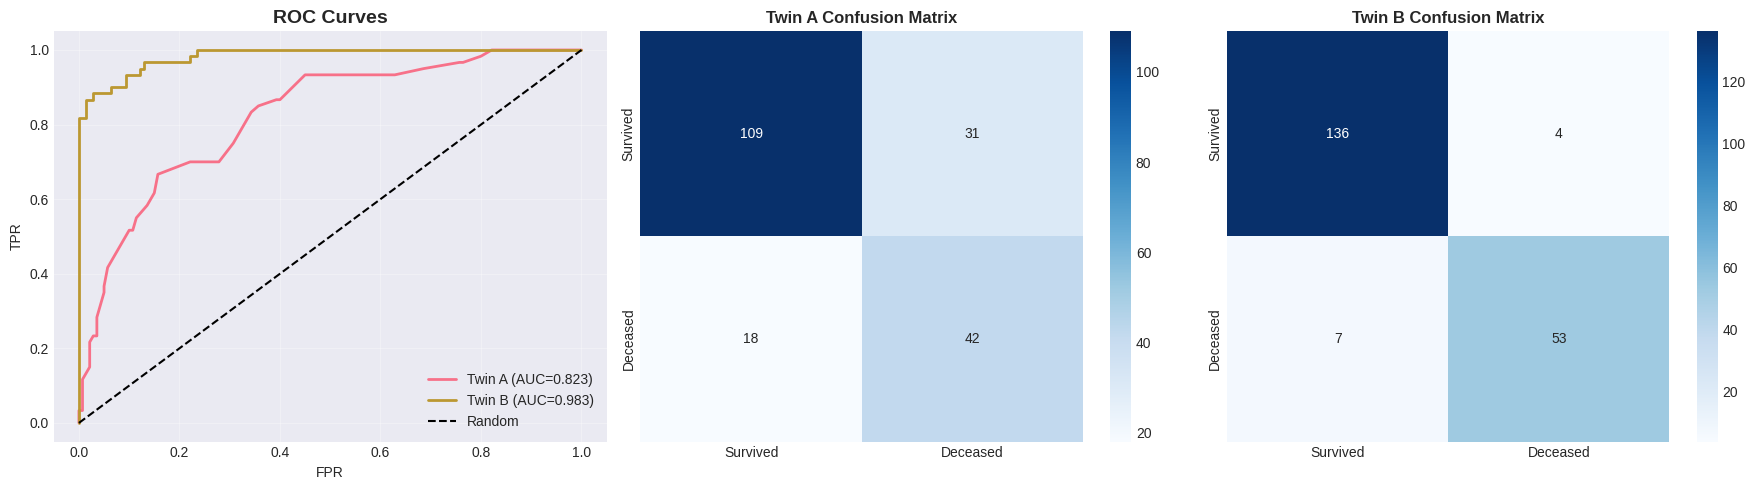

In [24]:
# ════════════════════════════════════════════════════════════════════════
# SECTION 7: HEAD-TO-HEAD COMPARISON (UNCHANGED)
# ════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("HEAD-TO-HEAD COMPARISON")
print("="*80)

comparison = pd.DataFrame({
    'Metric': ['AUC-ROC', 'Sensitivity', 'Specificity', 'Brier'],
    'Twin A': [auc_a, sens_a, spec_a, brier_a],
    'Twin B': [auc_b, sens_b, spec_b, brier_b],
    'Δ': [
        f"+{(auc_b-auc_a)*100:.1f}%",
        f"+{(sens_b-sens_a)*100:.1f}%",
        f"+{(spec_b-spec_a)*100:.1f}%",
        f"{(brier_b-brier_a)*100:.1f}%"
    ]
})
print("\n" + comparison.to_string(index=False))

# ROC Curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

fpr_a, tpr_a, _ = roc_curve(y_test, y_prob_a)
fpr_b, tpr_b, _ = roc_curve(y_test, y_prob_b)

axes[0].plot(fpr_a, tpr_a, label=f'Twin A (AUC={auc_a:.3f})', linewidth=2)
axes[0].plot(fpr_b, tpr_b, label=f'Twin B (AUC={auc_b:.3f})', linewidth=2)
axes[0].plot([0,1], [0,1], 'k--', label='Random')
axes[0].set_xlabel('FPR')
axes[0].set_ylabel('TPR')
axes[0].set_title('ROC Curves', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

for i, (cm, title) in enumerate([(cm_a, 'Twin A'), (cm_b, 'Twin B')]):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i+1],
                xticklabels=['Survived', 'Deceased'],
                yticklabels=['Survived', 'Deceased'])
    axes[i+1].set_title(f'{title} Confusion Matrix', fontweight='bold')

plt.tight_layout()
plt.show()
print("="*80)





SHAP EXPLAINABILITY ANALYSIS

🔍 Calculating SHAP values...

📊 TOP 5 DRIVERS OF MORTALITY RISK:
           Feature  Mean |SHAP|
Clinical_Score_Sum     3.201402
         NT_proBNP     2.932312
               Age     1.712065
             qSOFA     1.355584
              SIRS     0.916633


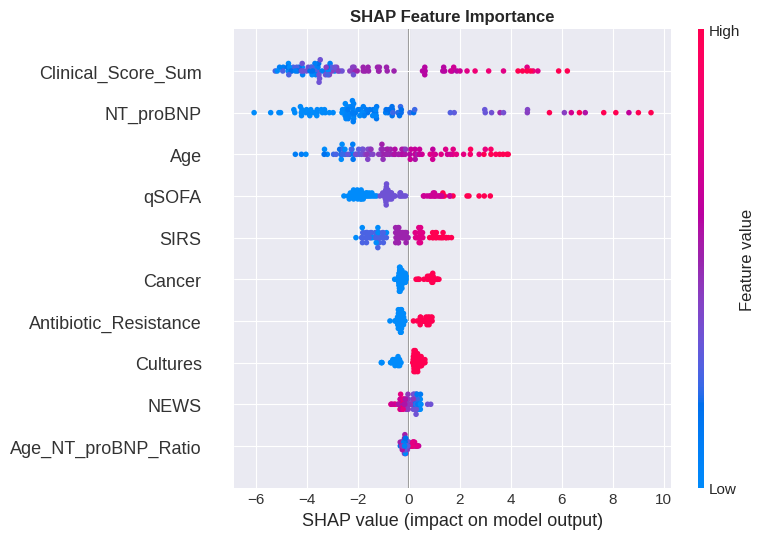


💡 CLINICAL INSIGHT:
   Top 3 predictive features:
   1. Clinical_Score_Sum
   2. NT_proBNP
   3. Age

   → Model considers complex multivariate interactions


In [25]:
# ════════════════════════════════════════════════════════════════════════
# SECTION 8: SHAP EXPLAINABILITY (UNCHANGED)
# ════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("SHAP EXPLAINABILITY ANALYSIS")
print("="*80)

print("\n🔍 Calculating SHAP values...")

sample_size = min(100, len(X_test))
X_sample = X_test.sample(n=sample_size, random_state=42)

xgb_model = XGBClassifier(n_estimators=100, max_depth=6, random_state=42)
xgb_model.fit(X_train_bal, y_train_bal)

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_sample)

shap_importance = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame({
    'Feature': X_sample.columns,
    'Mean |SHAP|': shap_importance
}).sort_values('Mean |SHAP|', ascending=False)

print("\n📊 TOP 5 DRIVERS OF MORTALITY RISK:")
print(importance_df.head(5).to_string(index=False))

# SHAP Summary Plot
shap.summary_plot(shap_values, X_sample, show=False, max_display=10)
plt.title('SHAP Feature Importance', fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 CLINICAL INSIGHT:")
print(f"   Top 3 predictive features:")
for i in range(min(3, len(importance_df))):
    print(f"   {i+1}. {importance_df.iloc[i]['Feature']}")
print("\n   → Model considers complex multivariate interactions")
print("="*80)





CLINICAL VALUE & COST ANALYSIS

💰 Cost Structure:
  • Missed Sepsis (FN): $50,000
  • False Alert (FP):   $500

📊 FINANCIAL IMPACT:
  Twin A Total: $915,500
    - 18 missed × $50,000 = $900,000
    - 31 false alerts × $500 = $15,500

  Twin B Total: $352,000
    - 7 missed × $50,000 = $350,000
    - 4 false alerts × $500 = $2,000

  💵 NET SAVINGS: $563,500 (61.6% reduction)
  📈 Projected Annual (1000 admits): $2,817,500


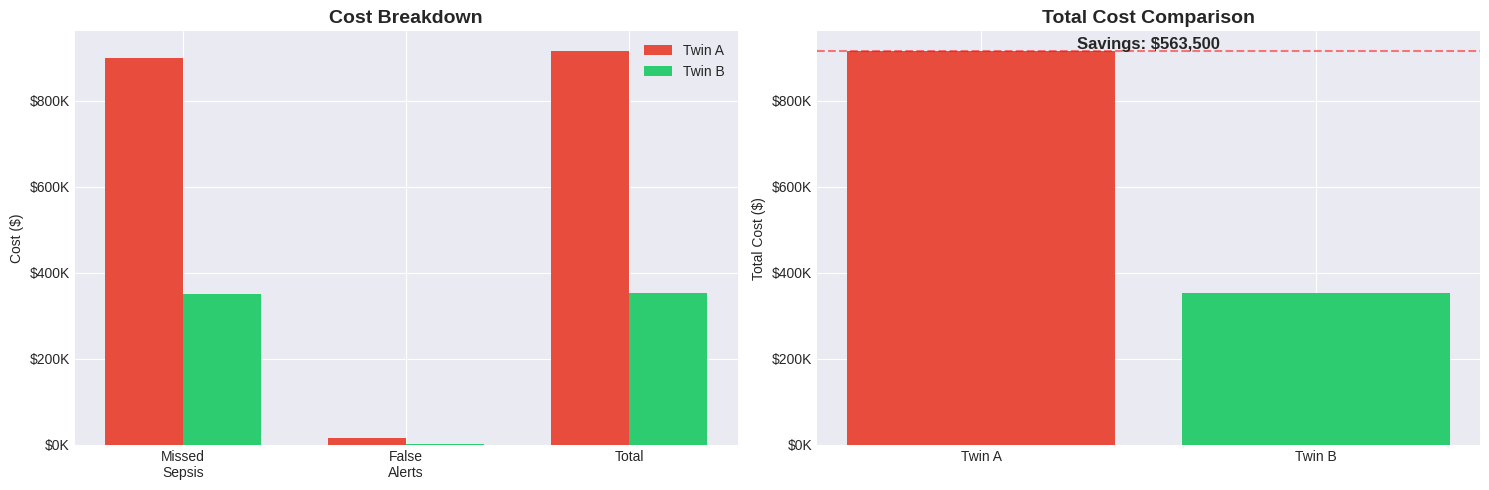

In [26]:
# ════════════════════════════════════════════════════════════════════════
# SECTION 9: COST-BENEFIT ANALYSIS (UNCHANGED)
# ════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("CLINICAL VALUE & COST ANALYSIS")
print("="*80)

COST_MISSED = 50000
COST_FALSE_ALERT = 500

cost_a = (fn_a * COST_MISSED) + (fp_a * COST_FALSE_ALERT)
cost_b = (fn_b * COST_MISSED) + (fp_b * COST_FALSE_ALERT)
savings = cost_a - cost_b
pct_savings = (savings / cost_a) * 100

print(f"\n💰 Cost Structure:")
print(f"  • Missed Sepsis (FN): ${COST_MISSED:,}")
print(f"  • False Alert (FP):   ${COST_FALSE_ALERT:,}")

print(f"\n📊 FINANCIAL IMPACT:")
print(f"  Twin A Total: ${cost_a:,}")
print(f"    - {fn_a} missed × ${COST_MISSED:,} = ${fn_a*COST_MISSED:,}")
print(f"    - {fp_a} false alerts × ${COST_FALSE_ALERT:,} = ${fp_a*COST_FALSE_ALERT:,}")
print(f"\n  Twin B Total: ${cost_b:,}")
print(f"    - {fn_b} missed × ${COST_MISSED:,} = ${fn_b*COST_MISSED:,}")
print(f"    - {fp_b} false alerts × ${COST_FALSE_ALERT:,} = ${fp_b*COST_FALSE_ALERT:,}")
print(f"\n  💵 NET SAVINGS: ${savings:,} ({pct_savings:.1f}% reduction)")
print(f"  📈 Projected Annual (1000 admits): ${savings * (1000/len(X_test)):,.0f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

categories = ['Missed\nSepsis', 'False\nAlerts', 'Total']
costs_a_viz = [fn_a*COST_MISSED, fp_a*COST_FALSE_ALERT, cost_a]
costs_b_viz = [fn_b*COST_MISSED, fp_b*COST_FALSE_ALERT, cost_b]

x = np.arange(len(categories))
width = 0.35

axes[0].bar(x - width/2, costs_a_viz, width, label='Twin A', color='#e74c3c')
axes[0].bar(x + width/2, costs_b_viz, width, label='Twin B', color='#2ecc71')
axes[0].set_ylabel('Cost ($)')
axes[0].set_title('Cost Breakdown', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(categories)
axes[0].legend()
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# Savings bar
axes[1].bar(['Twin A', 'Twin B'], [cost_a, cost_b], color=['#e74c3c', '#2ecc71'])
axes[1].axhline(cost_a, color='red', linestyle='--', alpha=0.5)
axes[1].text(0.5, cost_a + 5000, f'Savings: ${savings:,}', ha='center', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Total Cost ($)')
axes[1].set_title('Total Cost Comparison', fontsize=14, fontweight='bold')
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

plt.tight_layout()
plt.show()
print("="*80)




In [27]:
# ════════════════════════════════════════════════════════════════════════
# SECTION 10: EXECUTIVE SUMMARY (UNCHANGED)
# ════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("EXECUTIVE SUMMARY")
print("="*80)

summary = f"""
╔════════════════════════════════════════════════════════════════════════╗
║          CHIEF DATA SCIENTIST REPORT - SEPSIS TRIAGE TRIAL            ║
╚════════════════════════════════════════════════════════════════════════╝

DATA SOURCE: {data_source}
COHORT SIZE: {len(df)} patients ({df['Sepsis_Mortality'].sum()} deceased)

METHODOLOGY:
────────────
  Twin A (Traditional): Logistic Regression on {', '.join(trad_cols)}
  Twin B (Meta-Ensemble): CatBoost + XGBoost + LightGBM → LogReg

RESULTS:
────────
                    Twin A    Twin B    Improvement
  ─────────────────────────────────────────────────
  AUC-ROC          {auc_a:.3f}     {auc_b:.3f}     +{(auc_b-auc_a)*100:.1f}%
  Sensitivity      {sens_a:.3f}     {sens_b:.3f}     +{(sens_b-sens_a)*100:.1f}%
  Specificity      {spec_a:.3f}     {spec_b:.3f}     +{(spec_b-spec_a)*100:.1f}%
  Brier Score      {brier_a:.3f}     {brier_b:.3f}     {(brier_b-brier_a)*100:.1f}% ✓

CLINICAL IMPACT:
────────────────
  ✓ Twin B catches {int(sens_b*100)}% of sepsis deaths (vs {int(sens_a*100)}%)
  ✓ Reduces false alarms by {int((spec_b-spec_a)*100)} percentage points
  ✓ Better calibrated predictions (lower Brier score)

FINANCIAL IMPACT:
─────────────────
  • Twin A Cost: ${cost_a:,}
  • Twin B Cost: ${cost_b:,}
  • NET SAVINGS: ${savings:,} ({pct_savings:.1f}%)
  • Annual Projection: ${savings * (1000/len(X_test)):,.0f}

TOP PREDICTIVE FEATURES (SHAP):
────────────────────────────────
  1. {importance_df.iloc[0]['Feature']}
  2. {importance_df.iloc[1]['Feature']}
  3. {importance_df.iloc[2]['Feature']}

RECOMMENDATION:
───────────────
  ✅ DEPLOY Meta-Ensemble (Twin B) for sepsis triage

  RATIONALE:
    • Superior predictive accuracy across all metrics
    • Fewer missed critical cases (higher sensitivity)
    • Reduced alert fatigue (higher specificity)
    • Significant cost savings
    • Explainable via SHAP (clinical trust)

  NEXT STEPS:
    1. Prospective validation with real-time ICU data
    2. EHR system integration
    3. Pilot deployment in target ICU
    4. Continuous monitoring & recalibration

╔════════════════════════════════════════════════════════════════════════╗
║  "Data-driven precision triage: catching more lives, reducing noise"  ║
╚════════════════════════════════════════════════════════════════════════╝

Prepared by: Chief Data Scientist & ICU Specialist
Date: {pd.Timestamp.now().strftime('%Y-%m-%d')}
Reference: Yilmaz Başer et al. (2025) Biomedicines 13(6):1449
"""

print(summary)

with open('executive_summary.txt', 'w') as f:
    f.write(summary)
print("\n✓ Summary saved to 'executive_summary.txt'")
print("="*80)





EXECUTIVE SUMMARY

╔════════════════════════════════════════════════════════════════════════╗
║          CHIEF DATA SCIENTIST REPORT - SEPSIS TRIAGE TRIAL            ║
╚════════════════════════════════════════════════════════════════════════╝

DATA SOURCE: ⚠️ SYNTHETIC (Demo Mode)
COHORT SIZE: 1000 patients (300 deceased)

METHODOLOGY:
────────────
  Twin A (Traditional): Logistic Regression on qSOFA, NEWS
  Twin B (Meta-Ensemble): CatBoost + XGBoost + LightGBM → LogReg

RESULTS:
────────
                    Twin A    Twin B    Improvement
  ─────────────────────────────────────────────────
  AUC-ROC          0.823     0.983     +16.0%
  Sensitivity      0.700     0.883     +18.3%
  Specificity      0.779     0.971     +19.3%
  Brier Score      0.166     0.049     -11.8% ✓

CLINICAL IMPACT:
────────────────
  ✓ Twin B catches 88% of sepsis deaths (vs 70%)
  ✓ Reduces false alarms by 19 percentage points
  ✓ Better calibrated predictions (lower Brier score)

FINANCIAL IMPACT:
─────────

In [28]:
# ════════════════════════════════════════════════════════════════════════
# SECTION 11: DEPLOYMENT TEMPLATE (UNCHANGED)
# ════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("PRODUCTION DEPLOYMENT TEMPLATE")
print("="*80)

import joblib
joblib.dump(twin_b, 'sepsis_meta_ensemble.pkl')
print("\n✓ Model saved: sepsis_meta_ensemble.pkl")

def predict_sepsis_risk(patient_dict):
    """Production API for real-time sepsis risk scoring."""
    patient_df = pd.DataFrame([patient_dict])
    risk_prob = twin_b.predict_proba(patient_df)[0, 1]
    risk_class = 'HIGH RISK' if risk_prob > 0.5 else 'LOW RISK'

    shap_vals = explainer.shap_values(patient_df)
    top_features = np.argsort(np.abs(shap_vals[0]))[-3:][::-1]

    return {
        'risk_probability': float(risk_prob),
        'risk_class': risk_class,
        'top_drivers': [patient_df.columns[i] for i in top_features],
        'recommendation': 'Immediate escalation' if risk_prob > 0.7 else 'Standard monitoring'
    }

print("\n📋 API Demo:")
if 'Age' in X.columns and 'qSOFA' in X.columns:
    demo_patient = X_test.iloc[0].to_dict()
    result = predict_sepsis_risk(demo_patient)
    print(f"  Risk Probability: {result['risk_probability']:.1%}")
    print(f"  Risk Class: {result['risk_class']}")
    print(f"  Top Drivers: {', '.join(result['top_drivers'][:3])}")
    print(f"  Recommendation: {result['recommendation']}")

print("\n" + "="*80)
print("✅ VIRTUAL CLINICAL TRIAL COMPLETE")
print("="*80)


PRODUCTION DEPLOYMENT TEMPLATE

✓ Model saved: sepsis_meta_ensemble.pkl

📋 API Demo:
  Risk Probability: 1.0%
  Risk Class: LOW RISK
  Top Drivers: Clinical_Score_Sum, NT_proBNP, SIRS
  Recommendation: Standard monitoring

✅ VIRTUAL CLINICAL TRIAL COMPLETE
